In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 

from skimage.io import imread, imshow
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import rgb2gray
from skimage.transform import resize
from imutils import contours

## 1. Definición de variables globales

In [13]:
img_height = 1000
img_width = 1000

cell_area_max = img_height/9 * img_width/9 

imagen_path = 'images/sudoku.jpg'
save_path = './images/numbers/cell'
save_extension_img = '.png'

## 2. Carga de imagen de entrada

Se recomienda lo más centrada en la cuadrícula del sudoku en sí.

In [46]:
image = cv2.imread(imagen_path)

## 3. Procesamiento de imagen

    - Recorte
    - Escala de grises
    - Suavizado
    - Umbralización adaptativa

In [47]:
image = cv2.resize(image, (img_height, img_width), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_blur = cv2.medianBlur(gray, 9)
thresh = cv2.adaptiveThreshold(image_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,35,5)

In [40]:
cv2.imshow('imagen', thresh)
cv2.waitKey(0)

-1

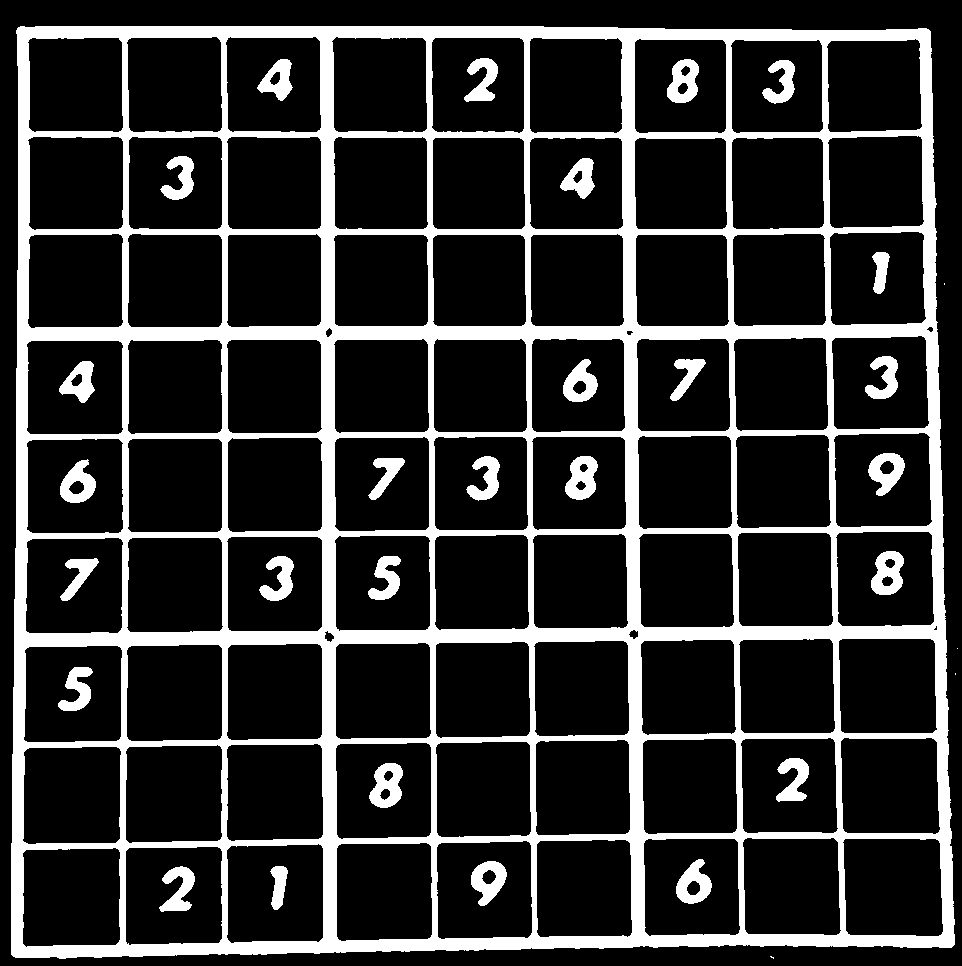

## 4. Eliminación de números y ruido

    - Se localizan los contornos de las celdas y se dibujan en negro las cuadrículas para eliminar tanto el ruido como los números del gird.
    - Se utilizan las funciones cv2.getStructuringElement y cv2.morphologyEx para mejorar las líneas verticales y horizontales de las celdas por si estuvieran cortadas.

In [48]:
# Filter out all numbers and noise to isolate only boxes
cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if (area < cell_area_max) and (area > cell_area_max/4):
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)

In [49]:
# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,3))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)

In [50]:
cv2.imshow('imagen', thresh)
cv2.waitKey(0)

-1

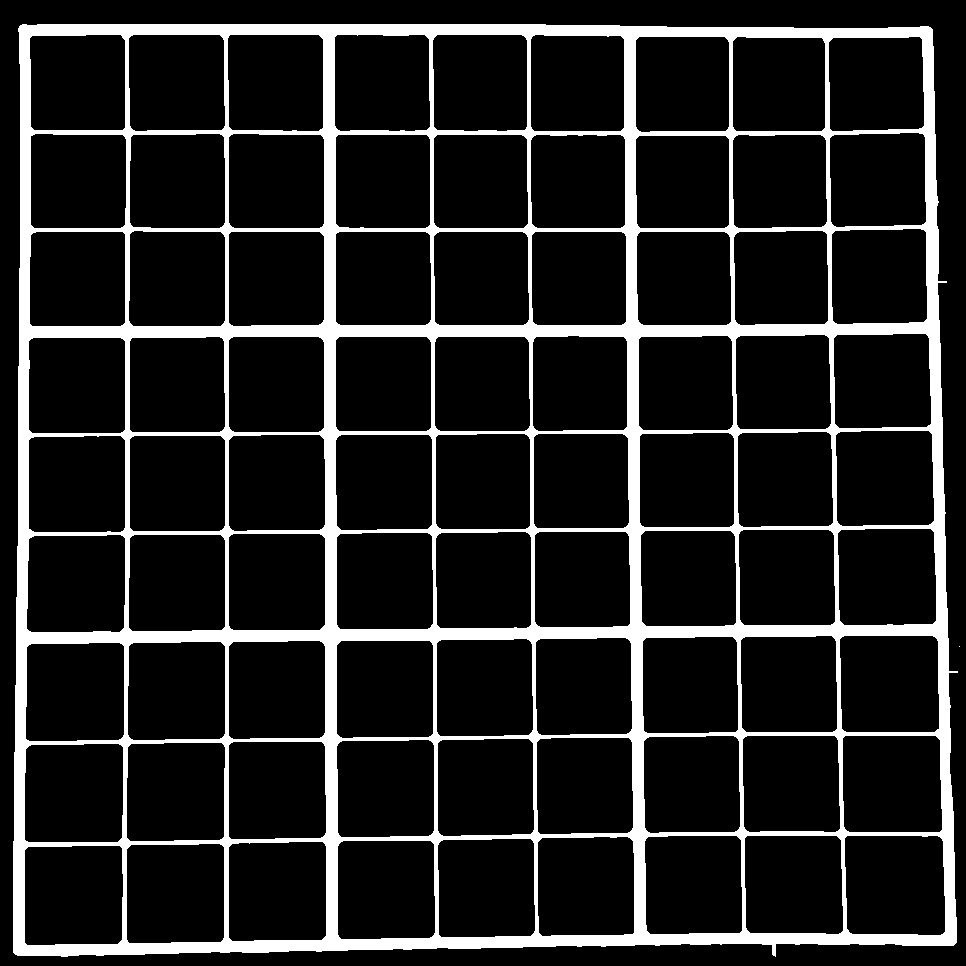

## 5. Ordenación de las coordenadas de las celdas

Se buscan las coordenadas de cada celda y se ordenan de arriba a abajo y de izquierda a derecha. Esto es necesario para saber, más adelaante, dónde (en qué celda) estará cada número localizado.

In [8]:
# Sort by top to bottom and each row by left to right
invert = 255 - thresh
cnts_ = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts_ = cnts_[0] if len(cnts_) == 2 else cnts_[1]

cnts = []
for c in cnts_:
    area = cv2.contourArea(c)
    #print(area)
    if (area < cell_area_max) and (area > cell_area_max/4):
        cnts.append(c)

(cnts, _) = contours.sort_contours(cnts, method = "top-to-bottom")


sudoku_rows = []
row = []
for (i, c) in enumerate(cnts, 1):  
    row.append(c)
    if i % 9 == 0:  
        (cnts, _) = contours.sort_contours(row, method = "left-to-right")
        sudoku_rows.append(cnts)
        row = []

## 6. Iteración para extraer las imágenes de las celdas con números

Para cada celda, se extraen las coordenadas de sus esquinas, se realizan operaciones de procesamiento de imágenes, se buscan áreas dentro de la celda y, si alguna de estas áreas tiene el tamaño fijado para el tamaño de los números, se hace recorte de esa celda en la imagen original y se guarda como imagen de celda con número para la próxima predicción.

In [11]:
#Bucle
ct = 0
for row in sudoku_rows:
    for c in row:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result[mask==0] = 255
        
        #Extracción de coordenadas para cada celda
        d = c[:,0]
        xMin = d[:,1].min()
        xMax = d[:,1].max()
        yMin = d[:,0].min()
        yMax = d[:,0].max()
        
        #Procesamiento de imagen
        gray_result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
        result_blur = cv2.medianBlur(gray_result, 9)
        ret, thresh_result = cv2.threshold(result_blur, 130, 255, cv2.THRESH_BINARY)
        
        #Bounding Box para buscar áreas
        label_result = label(thresh_result, background = 255)
        regions_result = regionprops(label_result)

        for props in regions_result:
            minr, minc, maxr, maxc = props.bbox
            area_result = (maxr - minr)*(maxc - minc)
            
            #Filtrado por área de Bounding Box
            if (area_result > cell_area_max/25) and (area_result < cell_area_max/4):              
                #Guardado de celdas con números
                salida = image.copy()
                salida_crop = image[xMin+15:xMax-25, yMin+22:yMax-17]
                cv2.imwrite(save_path + str(ct) + save_extension_img, salida_crop)
        ct += 1

        cv2.imshow('Grid', result)
        cv2.waitKey(100)
cv2.waitKey()

-1